In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# gp model
from GP import ExactGPModel, get_gp

# utility
import datetime
from typing import Tuple
from tqdm import tqdm

from utilities.processing_utility import get_q_2_cw_data, get_train_test_split


**GET DATA**

In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Normalised Excess Returns')

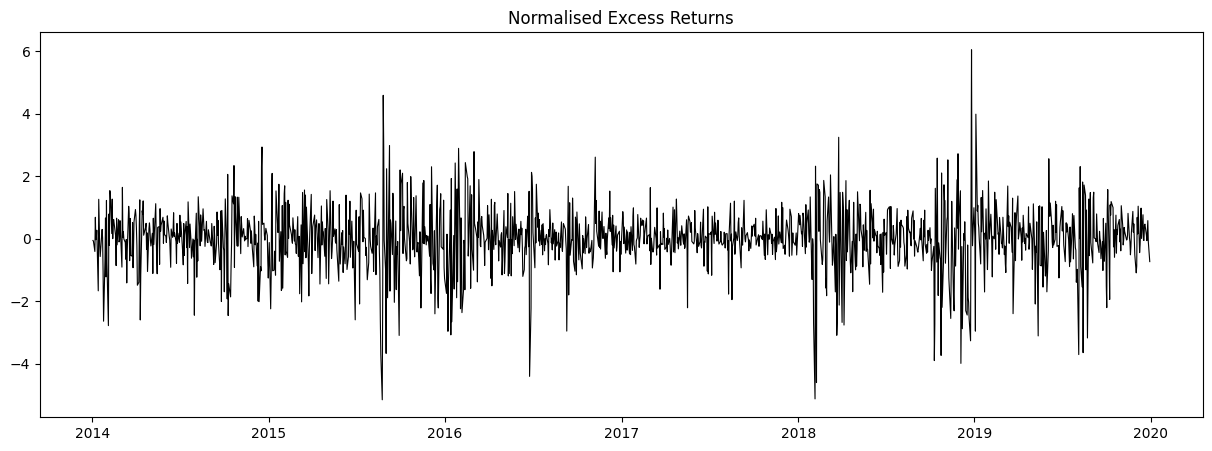

In [3]:
plt.plot(df['normalised_excess_returns'], color = 'black', lw = 0.8)

plt.title('Normalised Excess Returns')

In [4]:
# define train and test set 
y_data = torch.tensor(df['normalised_excess_returns'].values, dtype = torch.float32)
x_data = torch.arange(0, len(y_data), dtype = torch.float32).squeeze()

x_train, y_train, x_test, y_test = get_train_test_split(x_data, y_data, split = 0.7)

In [6]:
likelihood = gp.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [7]:
model.train()
likelihood.train()

training_iter = 50

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.408   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.405   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 1.390   lengthscale: 0.600   noise: 0.599
Iter 4/50 - Loss: 1.382   lengthscale: 0.557   noise: 0.556
Iter 5/50 - Loss: 1.375   lengthscale: 0.516   noise: 0.516
Iter 6/50 - Loss: 1.370   lengthscale: 0.480   noise: 0.480
Iter 7/50 - Loss: 1.369   lengthscale: 0.448   noise: 0.448
Iter 8/50 - Loss: 1.370   lengthscale: 0.418   noise: 0.423
Iter 9/50 - Loss: 1.373   lengthscale: 0.393   noise: 0.405
Iter 10/50 - Loss: 1.374   lengthscale: 0.370   noise: 0.395
Iter 11/50 - Loss: 1.374   lengthscale: 0.350   noise: 0.391
Iter 12/50 - Loss: 1.374   lengthscale: 0.332   noise: 0.394
Iter 13/50 - Loss: 1.373   lengthscale: 0.317   noise: 0.401
Iter 14/50 - Loss: 1.372   lengthscale: 0.304   noise: 0.412
Iter 15/50 - Loss: 1.370   lengthscale: 0.292   noise: 0.425
Iter 16/50 - Loss: 1.369   lengthscale: 0.282   noise: 0.439
Iter 17/50 - Loss: 1.368   length

In [8]:
# define x_test
N = len(y_train)
gp_range = torch.linspace(0, N, N*4)

x_range = torch.cat((gp_range, x_train))
x_range = torch.unique(x_range)

In [9]:
# get posterior
model.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    f_preds = model(x_range)

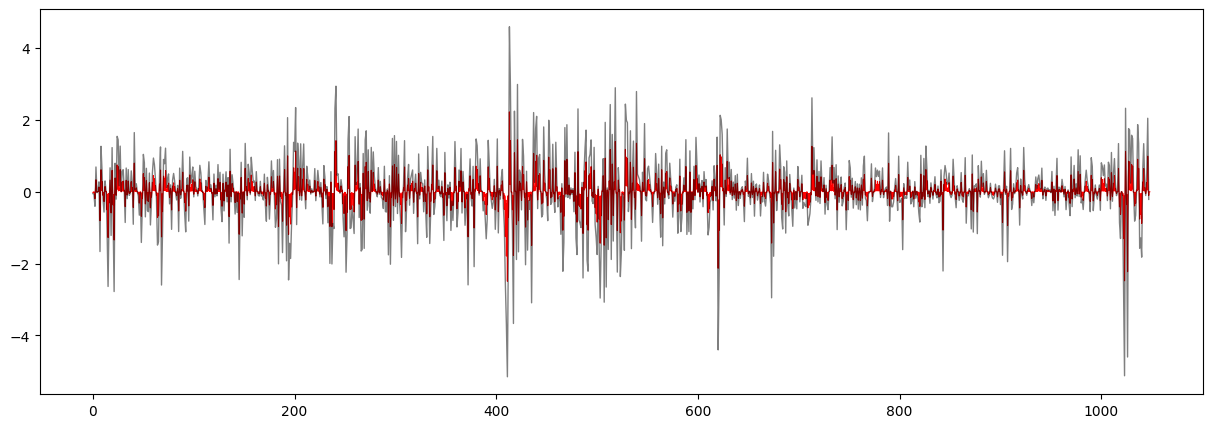

In [19]:
plt.plot(x_range, f_preds.mean, color = 'red', lw = 0.8)
plt.plot(x_train, y_train, color = 'black', lw = 1, alpha = 0.5)

In [24]:
train_threshold = 800
x_range_mask = x_range > train_threshold

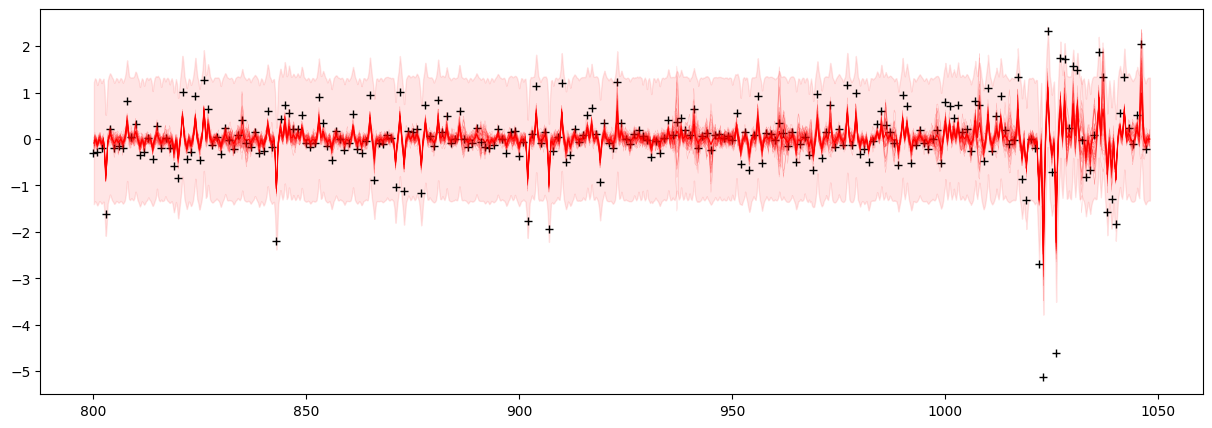

In [25]:
plt.figure(figsize=(15, 5))

plt.plot(x_range[x_range_mask], f_preds.mean[x_range_mask], label='GP mean', color='red', lw=0.8)

# train data
plt.plot(x_train[train_threshold:], y_train[train_threshold:], '+', label='Training data', color='black')

for i in range(50):
      f_samples = f_preds.rsample()
      plt.plot(x_range[x_range_mask], f_samples[x_range_mask], lw=.25, alpha=.25, color='red')

upper, lower = f_preds.confidence_region()

plt.fill_between(x_range[x_range_mask], lower[x_range_mask], upper[x_range_mask], alpha=0.1, color='red')

#plt.plot(x_train, y_train, color = 'black', lw = 1, alpha = 0.5)

# plt.scatter(x_test, y_test, marker='+', label='Test data', alpha = 1, color='blue', lw=.5)
# plt.plot(x_test, y_test, alpha = 0.5, color='blue')